# Project: Learning Betti Numbers with Neural Networks

This notebook compares two "vanilla" neural network architectures for predicting a graph's cyclomatic number (Betti number $\beta_1$) from its adjacency matrix.

1.  **Model 1:** A "from scratch" MLP using only NumPy.
2.  **Model 2:** A "sophisticated" MLP using PyTorch.

We will train both on the same dataset of random graphs and then test them on a set of specific, hand-crafted graphs.

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import time
from torch_geometric.data import Data, DataLoader as PyGDataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.utils import from_networkx

# Check for GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device.upper()}")

Using device: CPU


## Model 1: "Vanilla" NumPy Neural Network

This is the `BettiRegressorNN` class, built from scratch using only NumPy. It defines the forward pass, backward pass (backpropagation), and training loop.

In [2]:
class BettiRegressorNN:
    def __init__(self, input_size, hidden_size, output_size=1, learning_rate=0.001):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate

        # Standard weight initialization
        self.W1 = np.random.randn(self.hidden_size, self.input_size) * np.sqrt(2. / self.input_size)
        self.b1 = np.zeros((self.hidden_size, 1))
        self.W2 = np.random.randn(self.output_size, self.hidden_size) * np.sqrt(1. / self.hidden_size)
        self.b2 = np.zeros((self.output_size, 1))

    def _relu(self, Z):
        return np.maximum(0, Z)

    def _relu_derivative(self, Z):
        return Z > 0

    def _forward_pass(self, X):
        # We expect X to be (batch_size, num_features)
        # We transpose it to (num_features, batch_size) for easier matrix math
        X = X.T 
        Z1 = self.W1.dot(X) + self.b1
        A1 = self._relu(Z1)
        Z2 = self.W2.dot(A1) + self.b2
        A2 = Z2  # Linear activation for regression output
        
        # cache stores values needed for backprop
        cache = {"X_T": X, "Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2}
        return A2, cache

    def _backward_pass(self, Y, cache):
        # We expect Y to be (batch_size, 1)
        # We transpose it to (1, batch_size)
        Y = Y.T
        m = Y.shape[1] # Number of samples in the batch
        
        X_T, A1, A2, Z1 = cache['X_T'], cache['A1'], cache['A2'], cache['Z1']

        # Derivative for Mean Squared Error loss: 2 * (A2 - Y) / m
        # Simplified to dZ2 = A2 - Y, and we'll apply (1/m) to the gradient updates
        dZ2 = A2 - Y 
        dW2 = (1/m) * dZ2.dot(A1.T)
        db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)
        
        dA1 = self.W2.T.dot(dZ2)
        dZ1 = dA1 * self._relu_derivative(Z1)
        dW1 = (1/m) * dZ1.dot(X_T.T)
        db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)
        
        gradients = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}
        return gradients

    def _update_parameters(self, gradients):
        self.W1 -= self.learning_rate * gradients['dW1']
        self.b1 -= self.learning_rate * gradients['db1']
        self.W2 -= self.learning_rate * gradients['dW2']
        self.b2 -= self.learning_rate * gradients['db2']

    def train(self, X_train, Y_train, epochs=200, batch_size=64):
        print("Starting training (NumPy Model)...")
        start_time = time.time()
        for epoch in range(epochs):
            permutation = np.random.permutation(X_train.shape[0])
            X_shuffled, Y_shuffled = X_train[permutation], Y_train[permutation]

            for i in range(0, X_train.shape[0], batch_size):
                X_batch, Y_batch = X_shuffled[i:i+batch_size], Y_shuffled[i:i+batch_size]
                
                # Forward pass
                A2, cache = self._forward_pass(X_batch)
                
                # Backward pass
                gradients = self._backward_pass(Y_batch, cache)
                
                # Update parameters
                self._update_parameters(gradients)

            if (epoch + 1) % 50 == 0:
                # Note: This loss is calculated on the *last batch*, not the whole set
                loss = np.mean((A2 - Y_batch.T)**2) # Calculate MSE
                print(f"Epoch {epoch+1}/{epochs} - Training MSE Loss: {loss:.4f}")
        
        end_time = time.time()
        print(f"NumPy training finished. Total time: {end_time - start_time:.2f}s\n")

    def predict(self, X):
        predictions, _ = self._forward_pass(X)
        return predictions.T # Transpose back to (batch_size, 1)

## Model 2: "Sophisticated" PyTorch MLP

This is the `BettiMLP` class and its associated helper functions (`train`, `evaluate`, `predict`). It uses PyTorch's built-in layers, optimizers, and dataloaders.

In [3]:
class BettiMLP(nn.Module):
    """
    A PyTorch-based 'vanilla' neural network (MLP) with 3 hidden layers.
    It takes a flattened adjacency matrix as input.
    """
    def __init__(self, input_size=100, hidden_size=128, output_size=1):
        super(BettiMLP, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            # nn.Dropout(0.3),
            
            # nn.Linear(hidden_size, hidden_size*2),
            # nn.ReLU(),
            
            nn.Linear(hidden_size, output_size) # Regression output
        )

    def forward(self, x):
        return self.layers(x)

def train_pytorch_mlp(model, X_train, Y_train, epochs=200, batch_size=64, device='cpu'):
    """
    Trains the PyTorch MLP model.
    """
    model.to(device)
    
    # --- Prepare Data ---
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
    
    dataset = TensorDataset(X_train_tensor, Y_train_tensor)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # --- Loss and Optimizer ---
    criterion = nn.MSELoss() # Mean Squared Error for regression
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    print("Starting PyTorch MLP training...")
    start_time = time.time()
    
    for epoch in range(epochs):
        model.train() # Set model to training mode
        epoch_loss = 0.0
        
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
        if (epoch + 1) % 50 == 0:
            avg_loss = epoch_loss / len(loader)
            print(f"Epoch {epoch+1}/{epochs} - Training MSE Loss: {avg_loss:.4f}")
            
    end_time = time.time()
    print(f"PyTorch MLP training finished. Total time: {end_time - start_time:.2f}s\n")

def evaluate_pytorch_mlp(model, X_test, Y_test, device='cpu'):
    """
    Evaluates the trained PyTorch MLP model on the test set.
    """
    model.to(device)
    model.eval() # Set model to evaluation mode
    
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32) # Keep on CPU for numpy
    
    with torch.no_grad(): # Disable gradient calculations
        test_predictions_tensor = model(X_test_tensor)
    
    test_predictions = test_predictions_tensor.cpu().numpy()
    
    # Calculate metrics
    mae = np.mean(np.abs(test_predictions - Y_test))
    rounded_predictions = np.round(test_predictions)
    accuracy = np.mean(rounded_predictions == Y_test)
    
    print("--- PyTorch MLP Model Evaluation ---")
    print(f"Mean Absolute Error (MAE) on test set: {mae:.4f}")
    print(f"Accuracy of rounded predictions: {accuracy * 100:.2f}%")

def predict_single_graph_mlp(model, flat_adj_matrix, device='cpu'):
    """
    Predicts the Betti number for a single flattened adjacency matrix.
    """
    model.to(device)
    model.eval()
    
    # Ensure input is 2D (batch_size, num_features)
    if flat_adj_matrix.ndim == 1:
        flat_adj_matrix = flat_adj_matrix.reshape(1, -1)
        
    adj_tensor = torch.tensor(flat_adj_matrix, dtype=torch.float32).to(device)
    
    with torch.no_grad():
        prediction = model(adj_tensor)
        
    return prediction.cpu().item() # Return as a single Python number

## Model 3: "Sophisticated" PyTorch GNN

This is the Graph Neural Network (GNN). Instead of taking a flat vector, it operates directly on the graph's node and edge structure. It uses **Graph Convolutional Layers** (`GCNConv`) to learn node features and **Global Pooling** (`global_mean_pool`) to aggregate those features into a single prediction for the whole graph.

In [4]:
class BettiGNN(nn.Module):
    """
    A Graph Neural Network (GNN) for graph-level regression.
    """
    def __init__(self, num_node_features, hidden_channels):
        super(BettiGNN, self).__init__()
        torch.manual_seed(42)
        
        # Graph convolution layers
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels * 2)
        self.conv3 = GCNConv(hidden_channels * 2, hidden_channels)

        # A final MLP head for regression
        self.lin = nn.Linear(hidden_channels, 1)

    def forward(self, x, edge_index, batch):
        # 1. GNN layers learn node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Global pooling aggregates node features into a graph-level vector
        # `batch` tells the pooler which nodes belong to which graph
        x = global_mean_pool(x, batch)  

        # 3. Final MLP for regression
        x = nn.functional.dropout(x, p=0.4, training=self.training)
        x = self.lin(x)
        return x

def train_pytorch_gnn(model, loader, epochs=200, device='cpu'):
    """
    Trains the PyTorch GNN model.
    """
    model.to(device)
    criterion = nn.MSELoss() # Mean Squared Error for regression
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    print("Starting PyTorch GNN training...")
    start_time = time.time()
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        
        for data in loader:
            data = data.to(device) # Move batch of graphs to device
            
            optimizer.zero_grad()
            # The model takes all graph components as input
            outputs = model(data.x, data.edge_index, data.batch)
            loss = criterion(outputs, data.y.view(-1, 1))
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
        if (epoch + 1) % 50 == 0:
            avg_loss = epoch_loss / len(loader)
            print(f"Epoch {epoch+1}/{epochs} - Training MSE Loss: {avg_loss:.4f}")
            
    end_time = time.time()
    print(f"PyTorch GNN training finished. Total time: {end_time - start_time:.2f}s\n")

def evaluate_pytorch_gnn(model, loader, device='cpu'):
    """
    Evaluates the trained PyTorch GNN model on the test set.
    """
    model.to(device)
    model.eval()
    
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            outputs = model(data.x, data.edge_index, data.batch)
            
            predictions.append(outputs.cpu().numpy())
            true_labels.append(data.y.cpu().numpy())
    
    # Concatenate all batches
    predictions = np.concatenate(predictions, axis=0)
    true_labels = np.concatenate(true_labels, axis=0).reshape(-1, 1)

    # Calculate metrics
    mae = np.mean(np.abs(predictions - true_labels))
    rounded_predictions = np.round(predictions)
    accuracy = np.mean(rounded_predictions == true_labels)
    
    print("--- PyTorch GNN Model Evaluation ---")
    print(f"Mean Absolute Error (MAE) on test set: {mae:.4f}")
    print(f"Accuracy of rounded predictions: {accuracy * 100:.2f}%")

## Data Generation and Helper Functions

Here we define the functions to:
1.  `calculate_betti_number`: The "ground truth" analytical solution.
2.  `generate_betti_data_...`: Functions to create our training datasets.
3.  `make_homeomorphic_graphs_...`: Creates the specific graphs for our final test.

In [28]:
def calculate_betti_number(graph):
    """
    Calculates the first Betti number (cyclomatic number) of a graph.
    β₁ = m - n + c
    """
    m = graph.number_of_edges()
    n = graph.number_of_nodes()
    c = nx.number_connected_components(graph)
    return m - n + c

def generate_betti_data_uniform_edges(num_samples, num_vertices=10):
    """
    Generates random graphs with a uniform distribution of edge counts.
    """
    X, Y = [], []
    
    # Create a list of all possible edges for an undirected graph
    possible_edges = []
    for i in range(num_vertices):
        for j in range(i + 1, num_vertices):
            possible_edges.append((i, j))
    
    max_edges = len(possible_edges) # n*(n-1)/2
    
    for _ in range(num_samples):
        adj_matrix = np.zeros((num_vertices, num_vertices), dtype=int)
        
        # 1. Choose a number of edges uniformly
        num_edges = random.randint(0, max_edges)
        
        # 2. Shuffle the list of possible edges and select the first 'num_edges'
        random.shuffle(possible_edges)
        selected_edges = possible_edges[:num_edges]
        
        # 3. Build the adjacency matrix
        for u, v in selected_edges:
            adj_matrix[u, v] = 1
            adj_matrix[v, u] = 1
            
        # 4. Calculate Betti number and store
        G = nx.from_numpy_array(adj_matrix)
        betti_number = calculate_betti_number(G)
        
        X.append(adj_matrix.flatten())
        Y.append([betti_number])
        
    return np.array(X), np.array(Y)

def generate_betti_data_uniform_betti(num_samples, num_vertices=10, max_attempts=5_000_000):
    """
    Generates random graphs on `num_vertices` vertices, aiming for a uniform distribution
    over possible Betti numbers.
    """
    X, Y = [], []

    # List all possible undirected edges
    possible_edges = [(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices)]
    max_edges = len(possible_edges)
    betti_buckets = {}
    
    # Calculate a reasonable target, e.g., for 10 nodes, max betti is ~36
    max_possible_betti = max_edges - num_vertices + 1 
    target_per_betti = num_samples // (max_possible_betti // 2) # Heuristic
    
    print(f"Target ≈ {target_per_betti} graphs per Betti number category")
    attempts = 0
    while len(X) < num_samples and attempts < max_attempts:
        attempts += 1
        num_edges = random.randint(0, max_edges)
        random.shuffle(possible_edges)
        selected_edges = possible_edges[:num_edges]
        adj_matrix = np.zeros((num_vertices, num_vertices), dtype=int)
        for u, v in selected_edges:
            adj_matrix[u, v] = 1
            adj_matrix[v, u] = 1
        G = nx.from_numpy_array(adj_matrix)
        betti = calculate_betti_number(G)
        
        if betti < 0: continue
            
        if betti not in betti_buckets:
            betti_buckets[betti] = 0
            
        # Allow some oversampling, but cap it
        if betti_buckets[betti] < (target_per_betti + 50): 
            X.append(adj_matrix.flatten())
            Y.append([betti])
            betti_buckets[betti] += 1
            
        if len(X) >= num_samples:
            break
            
    print(f"Generated {len(X)} samples after {attempts} attempts.")
    print("Distribution of Betti numbers:")
    for k in sorted(betti_buckets):
        print(f"  β₁ = {k}: {betti_buckets[k]} samples")
    return np.array(X), np.array(Y)

def generate_tree_data(num_samples, num_vertices=10):
    """
    Generates *only* trees (β₁=0 graphs) to balance the dataset.
    """
    X, Y = [], []
    for _ in range(num_samples):
        # nx.random_tree() creates a perfect tree on n nodes
        G = nx.random_labeled_tree(n=num_vertices)
        
        # We need to pad it to a 10x10 matrix for the MLPs
        adj_matrix = np.zeros((num_vertices, num_vertices), dtype=int)
        for u, v in G.edges():
            adj_matrix[u, v] = 1
            adj_matrix[v, u] = 1
            
        # The label is always 0
        X.append(adj_matrix.flatten())
        Y.append([0])
        
    return np.array(X), np.array(Y)

def make_specific_graphs_on_10_vertices():
    graphs = {}

    # 1️⃣ Theta graph (β₁ = 2)
    G_theta = nx.Graph()
    G_theta.add_edges_from([
        (0,1),(1,2),(2,9),
        (0,3),(3,4),(4,9),
        (0,5),(5,6),(6,7),(7,8),(8,9)
    ])
    graphs["Theta (β₁=2)"] = G_theta

    # 2️⃣ Double theta graph (β₁ = 3)
    G_double_theta = nx.Graph()
    G_double_theta.add_edges_from([
        (0,1),(1,2),(2,9),
        (0,3),(3,4),(4,9),
        (0,5),(5,6),(6,9),
        (0,7),(7,8),(8,9)
    ])
    graphs["Double Theta (β₁=3)"] = G_double_theta

    # 3️⃣ Cube (β₁ = 4)
    G_cube = nx.cubical_graph() # 8 nodes, 12 edges. β₁ = 12-8+1 = 5
    while G_cube.number_of_nodes() < 10:
        u, v = list(G_cube.edges())[0]
        G_cube.remove_edge(u, v)
        new = max(G_cube.nodes()) + 1
        G_cube.add_node(new)
        G_cube.add_edges_from([(u, new), (new, v)])
    # m=13, n=10, c=1. β₁ = 13 - 10 + 1 = 4.
    graphs["Subdivided Cube (β₁=4)"] = G_cube

    # 4️⃣ C10 (β₁ = 1)
    G_c10 = nx.cycle_graph(10)
    graphs["C10 (β₁=1)"] = G_c10

    # 5️⃣ C5 + Path (β₁ = 1)
    G_c5_path = nx.cycle_graph(5)
    G_c5_path.add_nodes_from(range(5,10))
    G_c5_path.add_edges_from([(0,5),(5,6),(6,7),(7,8),(8,9)])
    # m = 5(c5) + 5(path) = 10. n = 10. c = 1. β₁ = 10-10+1 = 1
    graphs["C5+Path (β₁=1)"] = G_c5_path

    # 6️⃣ Path Tree (β₁ = 0)
    G_path = nx.path_graph(10)
    graphs["Path Tree (β₁=0)"] = G_path

    # 7️⃣ Star Tree (β₁ = 0)
    G_star = nx.star_graph(9) # Center 0, leaves 1-9
    graphs["Star Tree (β₁=0)"] = G_star

    # 8️⃣ Mercedes-Benz graph (β₁ = 3)
    G_mb = nx.Graph()
    G_mb.add_edges_from([
        (0,4),(4,1),(1,5),(5,2),(2,6),(6,3),(3,7),(7,1),
        (0,8),(8,9),(9,2),(5,8)
    ])
    # m=12, n=10, c=1. β₁ = 12-10+1 = 3
    graphs["Mercedes-Benz (β₁=3)"] = G_mb
    
    # 9. Two C5s (β₁ = 2)
    G_c5_c5 = nx.cycle_graph(5)
    G_c5_c5.add_nodes_from(range(5,10))
    G_c5_c5.add_edges_from(nx.cycle_graph(range(5,10)).edges())
    # m=10, n=10, c=2. β₁ = 10-10+2 = 2
    graphs["Two C5s (β₁=2)"] = G_c5_c5

    return graphs

## Visualization Harness

These functions will take our trained models and the test graphs, make predictions, and plot the results.

In [20]:
def adjacency_matrix(G):
    """Return adjacency matrix as NumPy array with node ordering 0..n-1."""
    # Ensure graph has 10 nodes for consistent 10x10 matrix
    num_nodes = G.number_of_nodes()
    if num_nodes != 10:
        G.add_nodes_from(range(num_nodes, 10))
    return nx.to_numpy_array(G, nodelist=range(10), dtype=int)

def predict_and_visualize_numpy(graphs, model):
    print("\n" + "="*30)
    print("  RUNNING NUMPY (MLP) MODEL  ")
    print("="*30)
    for name, G in graphs.items():
        adj = adjacency_matrix(G)
        true_betti = calculate_betti_number(G)
        
        x = adj.flatten().reshape(1, 100) # Hardcoded for 10x10
        predicted_betti = model.predict(x)[0][0]
        rounded_prediction = np.round(predicted_betti)

        print(f"\n===== {name} =====")
        print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}, Components: {nx.number_connected_components(G)}")
        print(f"True β₁ = {true_betti}")
        print(f"Predicted β₁ = {predicted_betti:.3f} (Rounded: {int(rounded_prediction)})")

        plt.figure(figsize=(6,6))
        pos = nx.spring_layout(G, seed=42)
        nx.draw(G, pos, with_labels=True, node_color="#33a3ff",
                node_size=700, font_color="white", width=2.0)
        title_color = "green" if true_betti == rounded_prediction else "red"
        plt.title(f"{name} (NumPy Model)\nTrue β₁: {true_betti} | Pred: {int(rounded_prediction)}",
                  fontsize=14, color=title_color)
        plt.show()

def predict_and_visualize_mlp(graphs, model, device='cpu'):
    print("\n" + "="*30)
    print("  RUNNING PYTORCH (MLP) MODEL  ")
    print("="*30)
    for name, G in graphs.items():
        adj = adjacency_matrix(G)
        true_betti = calculate_betti_number(G)

        x = adj.flatten()
        predicted_betti = predict_single_graph_mlp(model, x, device=device)
        rounded_prediction = np.round(predicted_betti)

        print(f"\n===== {name} =====")
        print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}, Components: {nx.number_connected_components(G)}")
        print(f"True β₁ = {true_betti}")
        print(f"Predicted β₁ = {predicted_betti:.3f} (Rounded: {int(rounded_prediction)})")

        plt.figure(figsize=(6,6))
        pos = nx.spring_layout(G, seed=42)
        nx.draw(G, pos, with_labels=True, node_color="#ff6b6b", # Red color for this model
                node_size=700, font_color="white", width=2.0)
        title_color = "green" if true_betti == rounded_prediction else "red"
        plt.title(f"{name} (PyTorch MLP)\nTrue β₁: {true_betti} | Pred: {int(rounded_prediction)}",
                  fontsize=14, color=title_color)
        plt.show()

def create_pyg_data_from_graph(G, num_nodes=10):
    """Helper to convert a single nx.Graph to a PyG Data object."""
    # Ensure graph has 10 nodes for consistent features
    if G.number_of_nodes() != num_nodes:
         G.add_nodes_from(range(G.number_of_nodes(), num_nodes))
            
    # Use an identity matrix as placeholder node features
    node_features = torch.eye(num_nodes, dtype=torch.float32)
    
    # 1. Convert the graph structure (nodes and edges)
    data = from_networkx(G)
    
    # 2. NOW, add the features and labels
    data.x = node_features
    data.y = torch.tensor([calculate_betti_number(G)], dtype=torch.float32)
    return data

def predict_and_visualize_gnn(graphs, model, device='cpu'):
    print("\n" + "="*30)
    print("  RUNNING PYTORCH (GNN) MODEL  ")
    print("="*30)
    for name, G in graphs.items():
        # Make a copy to avoid modifying the original graph
        G_copy = G.copy()
        true_betti = calculate_betti_number(G_copy)

        # Convert the nx.Graph to a PyG Data object for the GNN
        graph_data = create_pyg_data_from_graph(G_copy, num_nodes=NUM_VERTICES)
        
        # GNNs need a batch loader even for one graph
        single_graph_loader = PyGDataLoader([graph_data], batch_size=1)
        
        model.eval()
        model.to(device)
        predicted_betti = 0.0
        with torch.no_grad():
            for data in single_graph_loader:
                data = data.to(device)
                pred = model(data.x, data.edge_index, data.batch)
                predicted_betti = pred.cpu().item()
                
        rounded_prediction = np.round(predicted_betti)

        print(f"\n===== {name} =====")
        print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}, Components: {nx.number_connected_components(G)}")
        print(f"True β₁ = {true_betti}")
        print(f"Predicted β₁ = {predicted_betti:.3f} (Rounded: {int(rounded_prediction)})")

        plt.figure(figsize=(6,6))
        pos = nx.spring_layout(G, seed=42)
        nx.draw(G, pos, with_labels=True, node_color="#45b32e", # Green color
                node_size=700, font_color="white", width=2.0)
        title_color = "green" if true_betti == rounded_prediction else "red"
        plt.title(f"{name} (PyTorch GNN)\nTrue β₁: {true_betti} | Pred: {int(rounded_prediction)}",
                  fontsize=14, color=title_color)
        plt.show()

## Main Execution: Train, Evaluate, Visualize

This is the main part of the script. We'll generate the data, split it, train both models, evaluate them on the test set, and finally run the visualization harness.

In [29]:
# --- Hyperparameters ---
NUM_VERTICES = 10
INPUT_SIZE = NUM_VERTICES * NUM_VERTICES
HIDDEN_SIZE = 128
EPOCHS = 500
NUM_SAMPLES = 20000

# --- Generate Data (as NumPy arrays) ---
print("Generating Betti number dataset...")
# X, Y = generate_betti_data_uniform_edges(
#     num_samples=NUM_SAMPLES,
#     num_vertices=NUM_VERTICES
# )

# Let's use the more balanced generator
X_betti, Y_betti = generate_betti_data_uniform_betti(
    num_samples=NUM_SAMPLES,
    num_vertices=NUM_VERTICES
)

# --- NEW: Generate Tree Data ---
print("Generating tree (β₁=0) dataset...")
X_trees, Y_trees = generate_tree_data(
    num_samples=1000, # Add 5k guaranteed trees
    num_vertices=NUM_VERTICES
)

# --- NEW: Combine datasets ---
X_all = np.concatenate((X_betti, X_trees), axis=0)
Y_all = np.concatenate((Y_betti, Y_trees), axis=0)

# --- NEW: Shuffle the combined dataset ---
print("Shuffling combined dataset...")
permutation = np.random.permutation(X_all.shape[0])
X = X_all[permutation]
Y = Y_all[permutation]


split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
Y_train, Y_test = Y[:split_index], Y[split_index:]
print(f"Dataset created with {len(X_train)} training and {len(X_test)} test samples.")

Generating Betti number dataset...
Target ≈ 1111 graphs per Betti number category
Generated 20000 samples after 22616 attempts.
Distribution of Betti numbers:
  β₁ = 0: 1161 samples
  β₁ = 1: 1067 samples
  β₁ = 2: 734 samples
  β₁ = 3: 596 samples
  β₁ = 4: 585 samples
  β₁ = 5: 545 samples
  β₁ = 6: 544 samples
  β₁ = 7: 529 samples
  β₁ = 8: 469 samples
  β₁ = 9: 517 samples
  β₁ = 10: 518 samples
  β₁ = 11: 503 samples
  β₁ = 12: 510 samples
  β₁ = 13: 461 samples
  β₁ = 14: 471 samples
  β₁ = 15: 497 samples
  β₁ = 16: 481 samples
  β₁ = 17: 481 samples
  β₁ = 18: 479 samples
  β₁ = 19: 517 samples
  β₁ = 20: 496 samples
  β₁ = 21: 475 samples
  β₁ = 22: 474 samples
  β₁ = 23: 497 samples
  β₁ = 24: 528 samples
  β₁ = 25: 472 samples
  β₁ = 26: 461 samples
  β₁ = 27: 504 samples
  β₁ = 28: 480 samples
  β₁ = 29: 451 samples
  β₁ = 30: 515 samples
  β₁ = 31: 486 samples
  β₁ = 32: 491 samples
  β₁ = 33: 517 samples
  β₁ = 34: 510 samples
  β₁ = 35: 495 samples
  β₁ = 36: 483 sample

### GNN Data Preparation

The MLPs use flat vectors, but the GNN needs `torch_geometric.data.Data` objects. We'll create a helper function to convert our NumPy data into a list of these graph objects.

In [39]:
def create_pyg_dataset(X_matrices, Y_labels, num_nodes):
    pyg_list = []
    # Node features will be an identity matrix (one-hot encoding of node ID)
    node_features = torch.eye(num_nodes, dtype=torch.float32)
    
    for i in range(len(X_matrices)):
        adj_matrix = X_matrices[i].reshape(num_nodes, num_nodes)
        label = Y_labels[i][0]
        
        # Convert adjacency matrix to edge_index format (COO)
        # This is what PyG prefers
        edge_index_coo = torch.tensor(np.array(adj_matrix.nonzero()), dtype=torch.long)
        
        data = Data(
            x=node_features, 
            edge_index=edge_index_coo, 
            y=torch.tensor([label], dtype=torch.float32)
        )
        pyg_list.append(data)
    return pyg_list

print("Converting data for GNN...")
pyg_train_dataset = create_pyg_dataset(X_train, Y_train, NUM_VERTICES)
pyg_test_dataset = create_pyg_dataset(X_test, Y_test, NUM_VERTICES)

# PyG has its own DataLoader that can batch graphs of different sizes
gnn_train_loader = PyGDataLoader(pyg_train_dataset, batch_size=64, shuffle=True)
gnn_test_loader = PyGDataLoader(pyg_test_dataset, batch_size=64, shuffle=False)
print("GNN data prepared.")

Converting data for GNN...
GNN data prepared.


/var/folders/gz/ky2s0gns2s3_5dkgxw9rg4cr0000gn/T/ipykernel_52384/3603783229.py:27: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  gnn_train_loader = PyGDataLoader(pyg_train_dataset, batch_size=64, shuffle=True)
/var/folders/gz/ky2s0gns2s3_5dkgxw9rg4cr0000gn/T/ipykernel_52384/3603783229.py:28: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  gnn_test_loader = PyGDataLoader(pyg_test_dataset, batch_size=64, shuffle=False)


### Train Model 1: NumPy MLP

In [31]:
# --- 1. Train NumPy Network ---
betti_nn = BettiRegressorNN(
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE
)
betti_nn.train(X_train, Y_train, epochs=EPOCHS)

Starting training (NumPy Model)...
Epoch 50/500 - Training MSE Loss: 0.3693
Epoch 100/500 - Training MSE Loss: 0.1781
Epoch 150/500 - Training MSE Loss: 0.1418
Epoch 200/500 - Training MSE Loss: 0.1064
Epoch 250/500 - Training MSE Loss: 0.1138
Epoch 300/500 - Training MSE Loss: 0.2043
Epoch 350/500 - Training MSE Loss: 0.0498
Epoch 400/500 - Training MSE Loss: 0.1153
Epoch 450/500 - Training MSE Loss: 0.1002
Epoch 500/500 - Training MSE Loss: 0.1101
NumPy training finished. Total time: 14.63s



### Train Model 2: PyTorch MLP

In [32]:
# --- 2. Train PyTorch MLP Network ---
pytorch_mlp = BettiMLP(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE)
train_pytorch_mlp(pytorch_mlp, X_train, Y_train, epochs=EPOCHS, device=device)

Starting PyTorch MLP training...
Epoch 50/500 - Training MSE Loss: 0.1003
Epoch 100/500 - Training MSE Loss: 0.0649
Epoch 150/500 - Training MSE Loss: 0.0492
Epoch 200/500 - Training MSE Loss: 0.0368
Epoch 250/500 - Training MSE Loss: 0.0258
Epoch 300/500 - Training MSE Loss: 0.0212
Epoch 350/500 - Training MSE Loss: 0.0188
Epoch 400/500 - Training MSE Loss: 0.0160
Epoch 450/500 - Training MSE Loss: 0.0165
Epoch 500/500 - Training MSE Loss: 0.0124
PyTorch MLP training finished. Total time: 47.77s



### Train Model 3: PyTorch GNN

In [33]:
# --- 3. Train PyTorch GNN Network ---
# The GNN's input features are the rows of our identity matrix
# so num_node_features is NUM_VERTICES
pytorch_gnn = BettiGNN(num_node_features=NUM_VERTICES, hidden_channels=64)
train_pytorch_gnn(pytorch_gnn, gnn_train_loader, epochs=EPOCHS, device=device)

Starting PyTorch GNN training...
Epoch 50/500 - Training MSE Loss: 3.2211
Epoch 100/500 - Training MSE Loss: 2.2862
Epoch 150/500 - Training MSE Loss: 1.7653
Epoch 200/500 - Training MSE Loss: 1.6242
Epoch 250/500 - Training MSE Loss: 1.4750
Epoch 300/500 - Training MSE Loss: 1.5015
Epoch 350/500 - Training MSE Loss: 1.4772
Epoch 400/500 - Training MSE Loss: 1.4566
Epoch 450/500 - Training MSE Loss: 1.4188
Epoch 500/500 - Training MSE Loss: 1.4543
PyTorch GNN training finished. Total time: 636.43s



### Evaluate Both Models

In [36]:
# --- Evaluate NumPy Model ---
print("\n" + "="*30)
print("  FINAL MODEL EVALUATION  ")
print("="*30)
print("\nEvaluating NumPy model on the test set...")
test_predictions_numpy = betti_nn.predict(X_test)
mae_numpy = np.mean(np.abs(test_predictions_numpy - Y_test))
print(f"NumPy Model MAE: {mae_numpy:.4f}")
rounded_predictions_numpy = np.round(test_predictions_numpy)
accuracy_numpy = np.mean(rounded_predictions_numpy == Y_test)
print(f"NumPy Model Accuracy: {accuracy_numpy * 100:.2f}%")


  FINAL MODEL EVALUATION  

Evaluating NumPy model on the test set...
NumPy Model MAE: 0.2019
NumPy Model Accuracy: 86.19%


In [34]:
# --- Evaluate PyTorch MLP Model ---
print("\nEvaluating PyTorch MLP model on the test set...")
evaluate_pytorch_mlp(pytorch_mlp, X_test, Y_test, device=device)


Evaluating PyTorch MLP model on the test set...
--- PyTorch MLP Model Evaluation ---
Mean Absolute Error (MAE) on test set: 0.1649
Accuracy of rounded predictions: 90.60%


In [35]:
# --- Evaluate PyTorch GNN Model ---
print("\nEvaluating PyTorch GNN model on the test set...")
evaluate_pytorch_gnn(pytorch_gnn, gnn_test_loader, device=device)


Evaluating PyTorch GNN model on the test set...
--- PyTorch GNN Model Evaluation ---
Mean Absolute Error (MAE) on test set: 0.2024
Accuracy of rounded predictions: 94.36%


### Final Visualization Test


  RUNNING NUMPY (MLP) MODEL  

===== Theta (β₁=2) =====
Nodes: 10, Edges: 11, Components: 1
True β₁ = 2
Predicted β₁ = 1.985 (Rounded: 2)


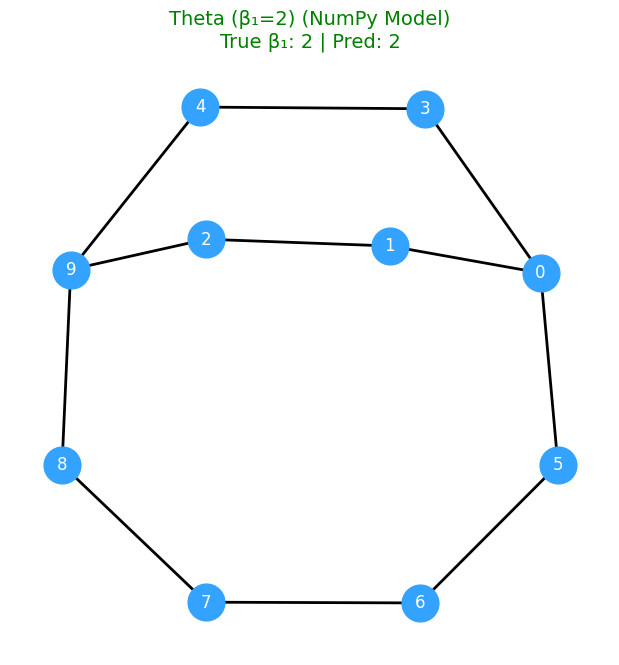


===== Double Theta (β₁=3) =====
Nodes: 10, Edges: 12, Components: 1
True β₁ = 3
Predicted β₁ = 3.031 (Rounded: 3)


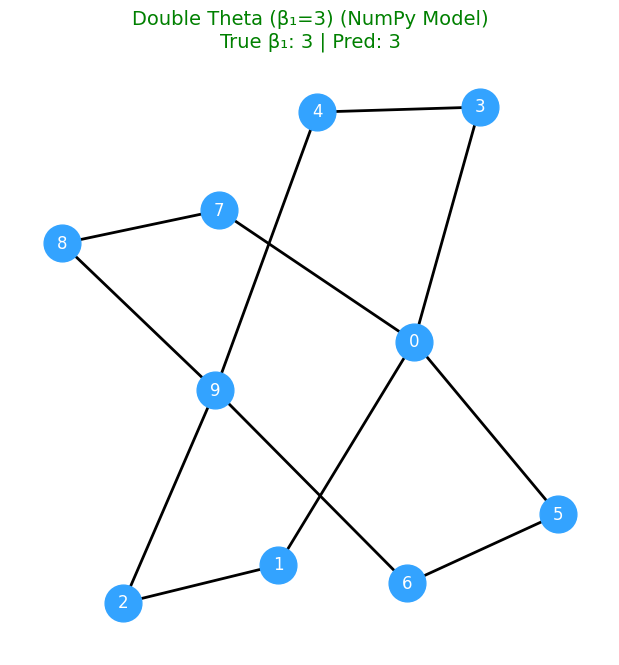


===== Subdivided Cube (β₁=4) =====
Nodes: 10, Edges: 14, Components: 1
True β₁ = 5
Predicted β₁ = 4.981 (Rounded: 5)


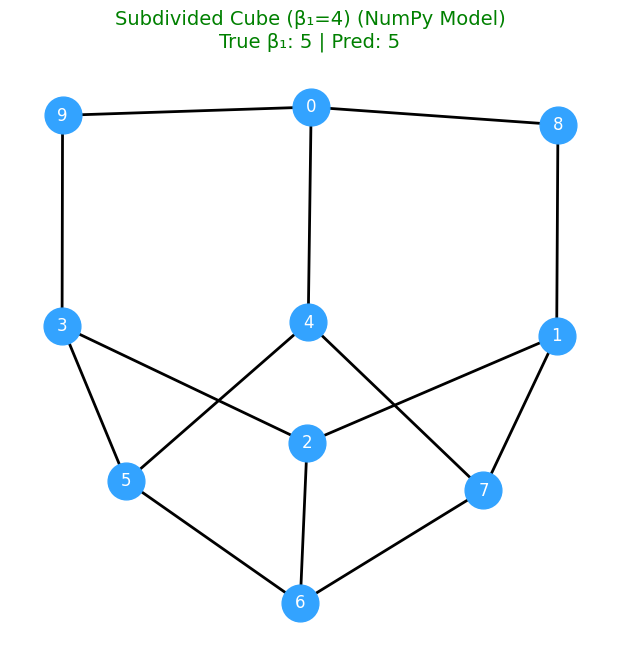


===== C10 (β₁=1) =====
Nodes: 10, Edges: 10, Components: 1
True β₁ = 1
Predicted β₁ = 1.283 (Rounded: 1)


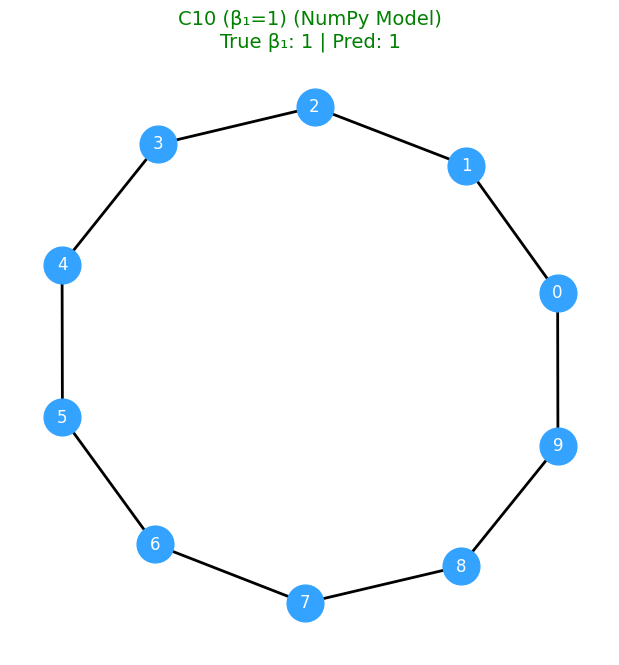


===== C5+Path (β₁=1) =====
Nodes: 10, Edges: 10, Components: 1
True β₁ = 1
Predicted β₁ = 1.255 (Rounded: 1)


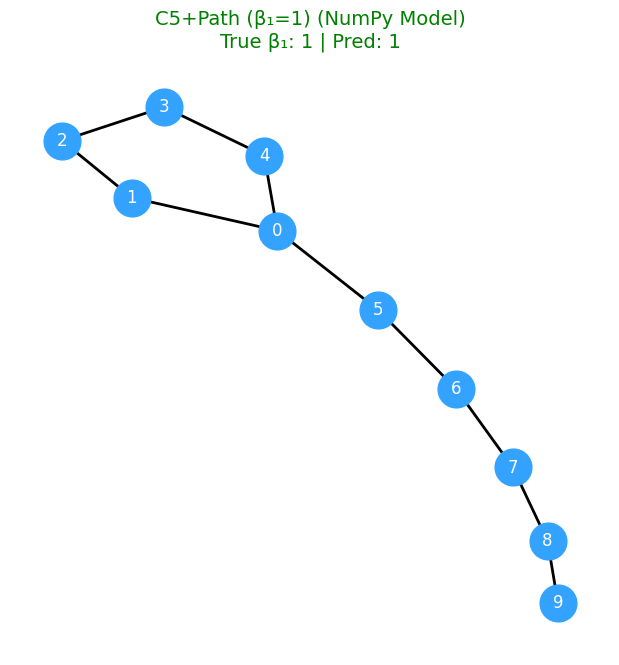


===== Path Tree (β₁=0) =====
Nodes: 10, Edges: 9, Components: 1
True β₁ = 0
Predicted β₁ = 0.631 (Rounded: 1)


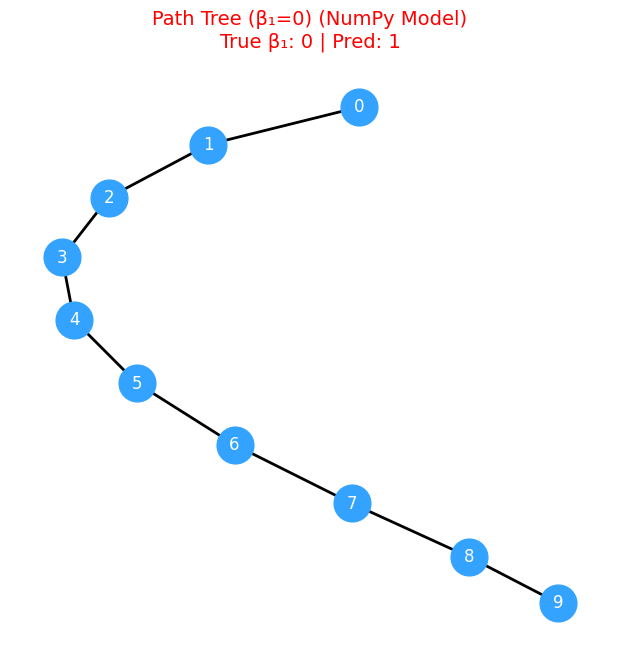


===== Star Tree (β₁=0) =====
Nodes: 10, Edges: 9, Components: 1
True β₁ = 0
Predicted β₁ = 2.422 (Rounded: 2)


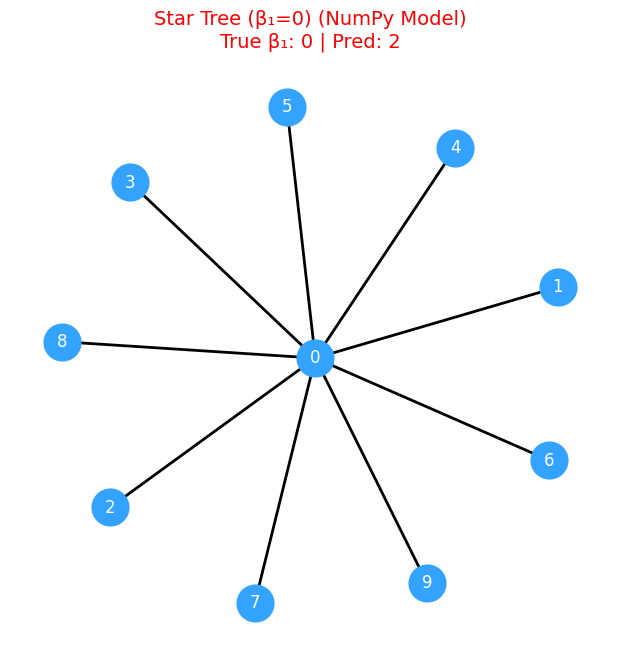


===== Mercedes-Benz (β₁=3) =====
Nodes: 10, Edges: 12, Components: 1
True β₁ = 3
Predicted β₁ = 3.088 (Rounded: 3)


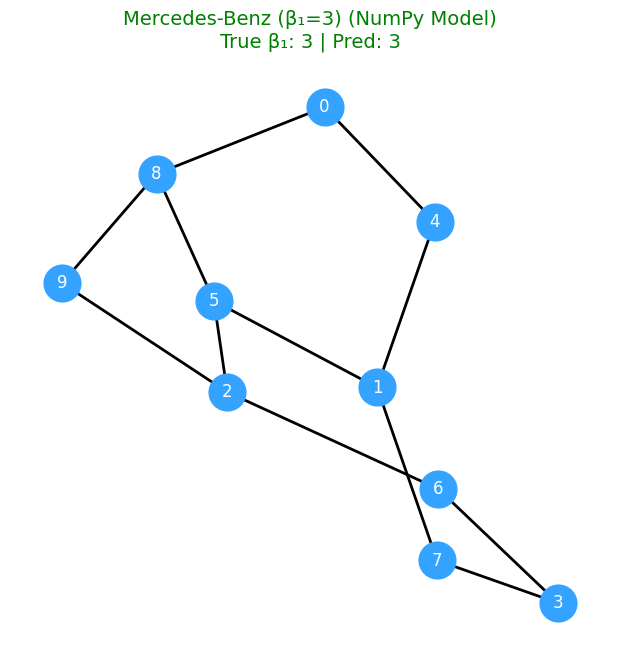


===== Two C5s (β₁=2) =====
Nodes: 10, Edges: 10, Components: 2
True β₁ = 2
Predicted β₁ = 1.268 (Rounded: 1)


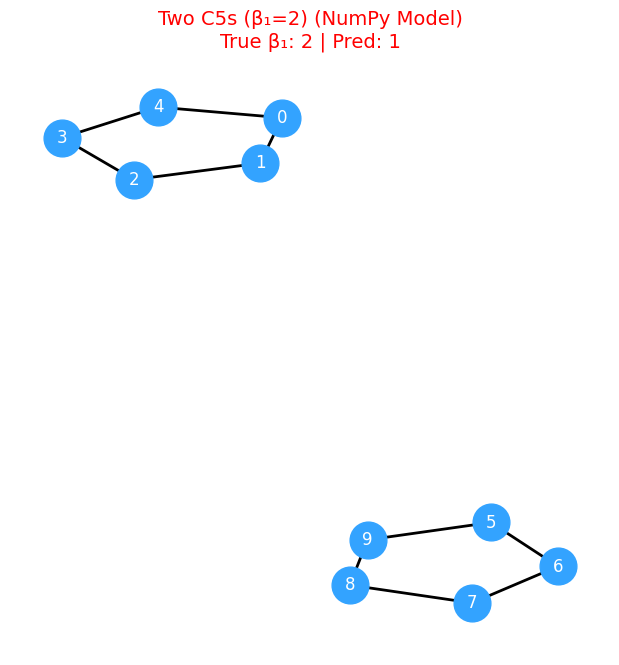


  RUNNING PYTORCH (MLP) MODEL  

===== Theta (β₁=2) =====
Nodes: 10, Edges: 11, Components: 1
True β₁ = 2
Predicted β₁ = 1.882 (Rounded: 2)


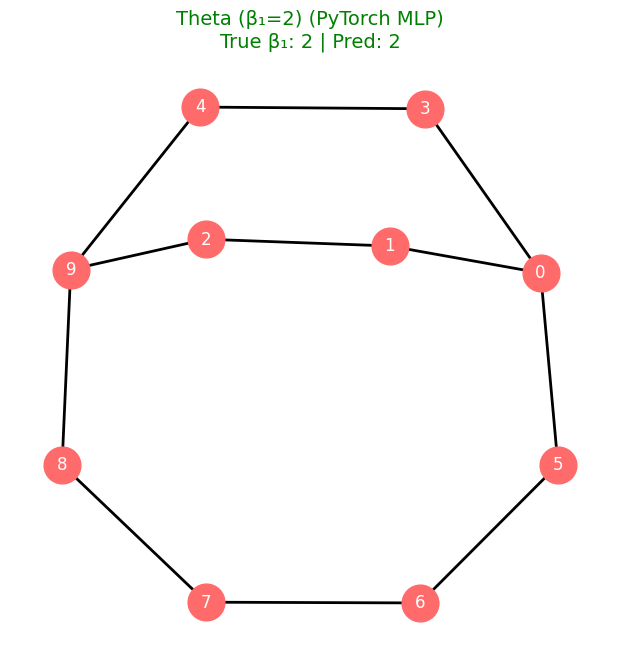


===== Double Theta (β₁=3) =====
Nodes: 10, Edges: 12, Components: 1
True β₁ = 3
Predicted β₁ = 2.813 (Rounded: 3)


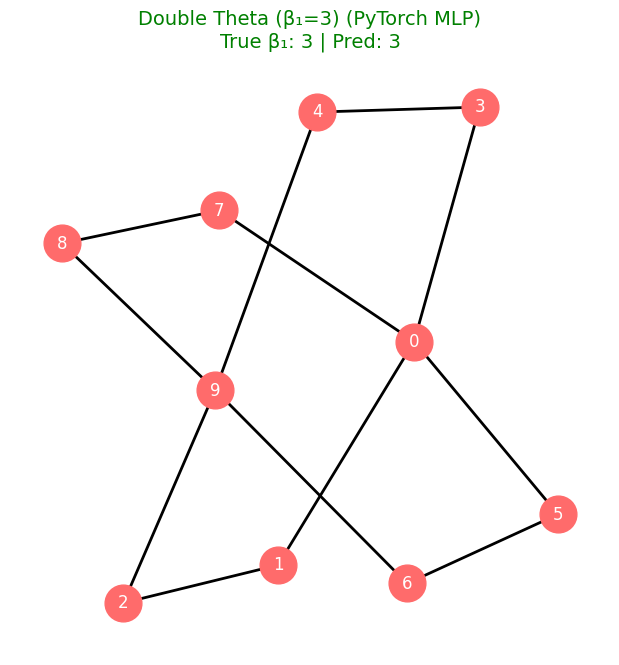


===== Subdivided Cube (β₁=4) =====
Nodes: 10, Edges: 14, Components: 1
True β₁ = 5
Predicted β₁ = 4.984 (Rounded: 5)


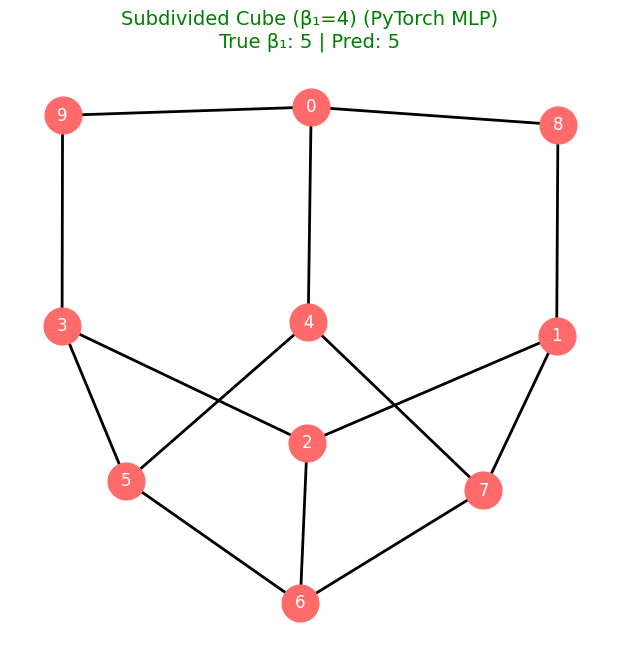


===== C10 (β₁=1) =====
Nodes: 10, Edges: 10, Components: 1
True β₁ = 1
Predicted β₁ = -0.006 (Rounded: 0)


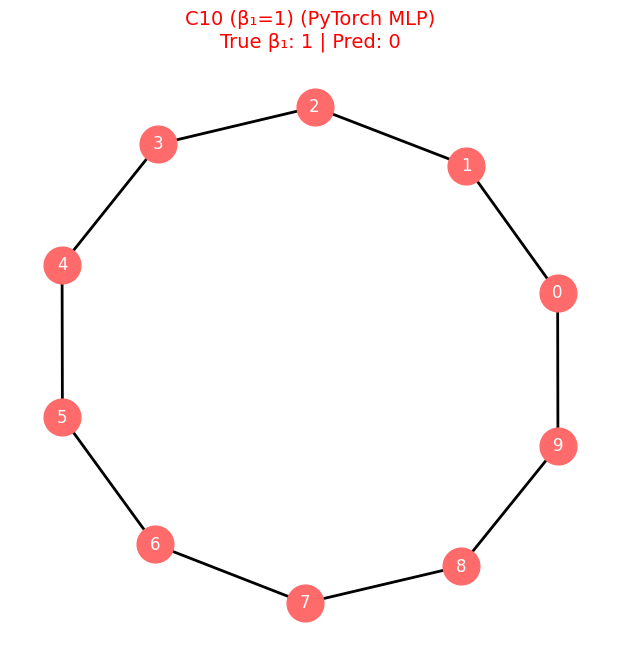


===== C5+Path (β₁=1) =====
Nodes: 10, Edges: 10, Components: 1
True β₁ = 1
Predicted β₁ = 0.466 (Rounded: 0)


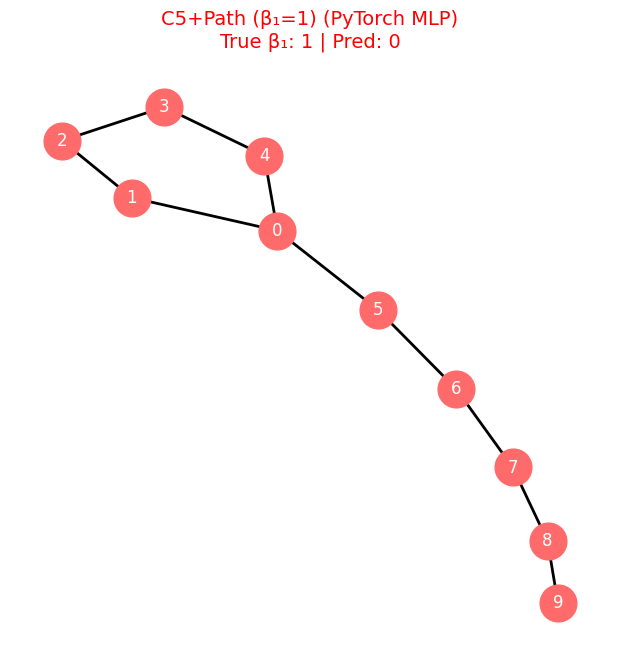


===== Path Tree (β₁=0) =====
Nodes: 10, Edges: 9, Components: 1
True β₁ = 0
Predicted β₁ = -0.555 (Rounded: -1)


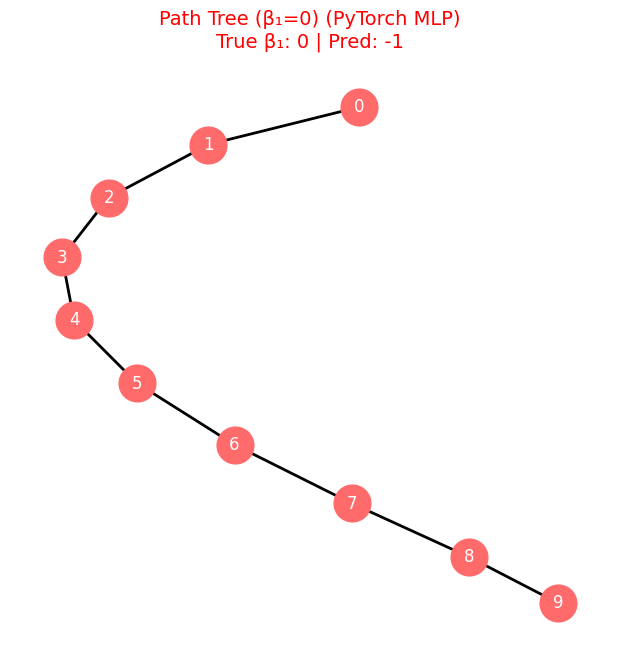


===== Star Tree (β₁=0) =====
Nodes: 10, Edges: 9, Components: 1
True β₁ = 0
Predicted β₁ = 0.771 (Rounded: 1)


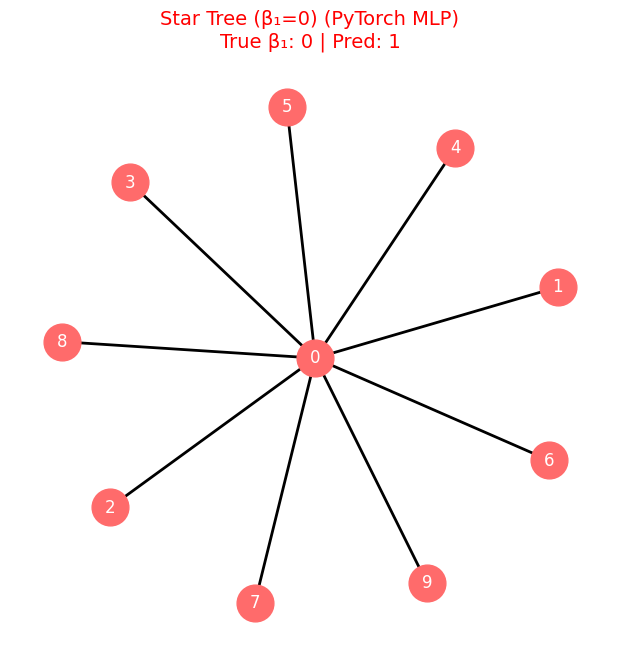


===== Mercedes-Benz (β₁=3) =====
Nodes: 10, Edges: 12, Components: 1
True β₁ = 3
Predicted β₁ = 2.935 (Rounded: 3)


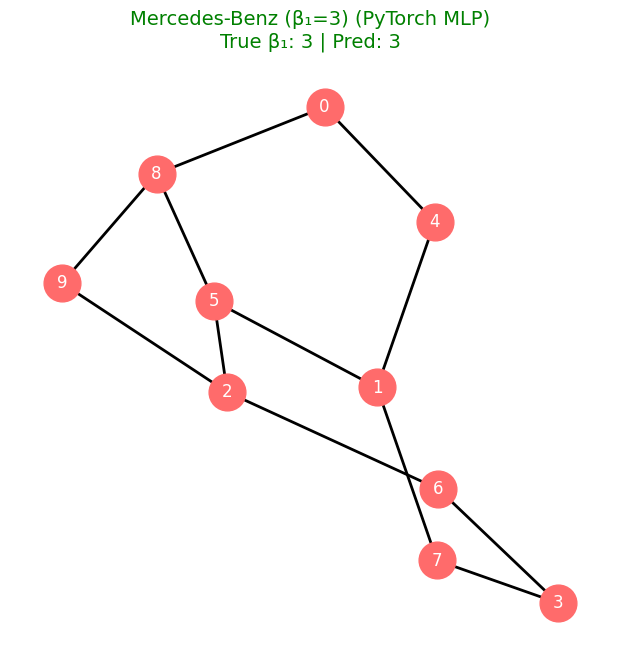


===== Two C5s (β₁=2) =====
Nodes: 10, Edges: 10, Components: 2
True β₁ = 2
Predicted β₁ = 0.187 (Rounded: 0)


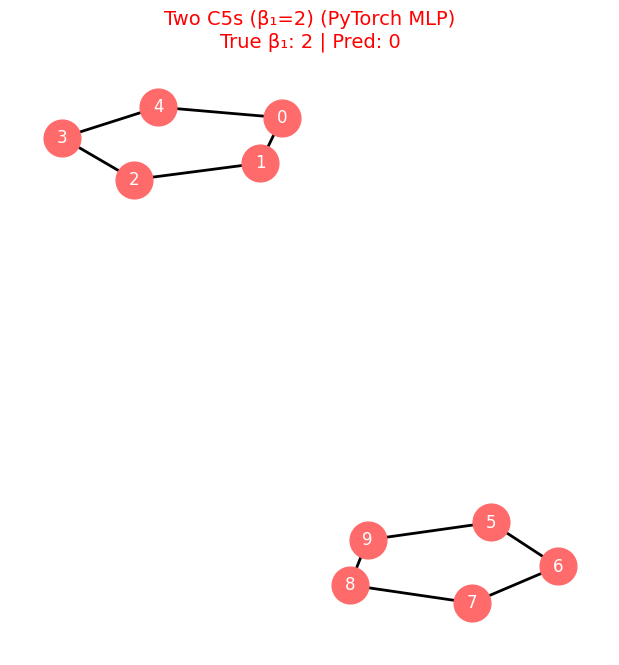


  RUNNING PYTORCH (GNN) MODEL  

===== Theta (β₁=2) =====
Nodes: 10, Edges: 11, Components: 1
True β₁ = 2
Predicted β₁ = 2.075 (Rounded: 2)


/var/folders/gz/ky2s0gns2s3_5dkgxw9rg4cr0000gn/T/ipykernel_52384/210038708.py:91: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  single_graph_loader = PyGDataLoader([graph_data], batch_size=1)


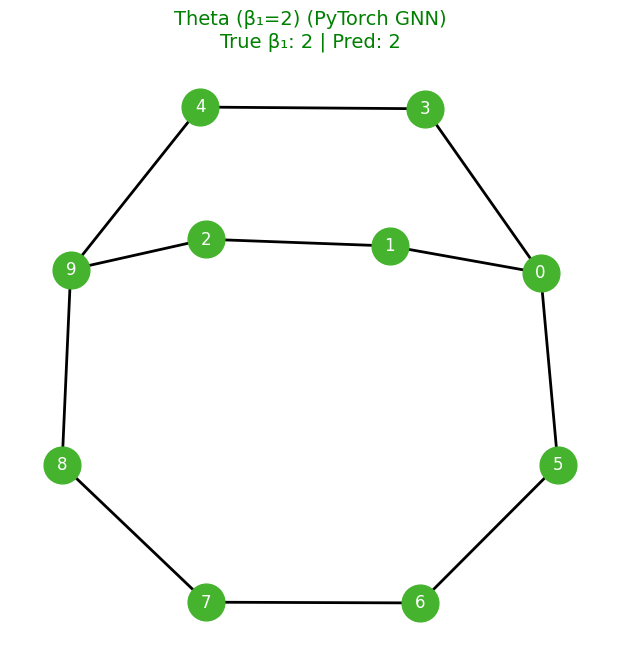


===== Double Theta (β₁=3) =====
Nodes: 10, Edges: 12, Components: 1
True β₁ = 3
Predicted β₁ = 2.963 (Rounded: 3)


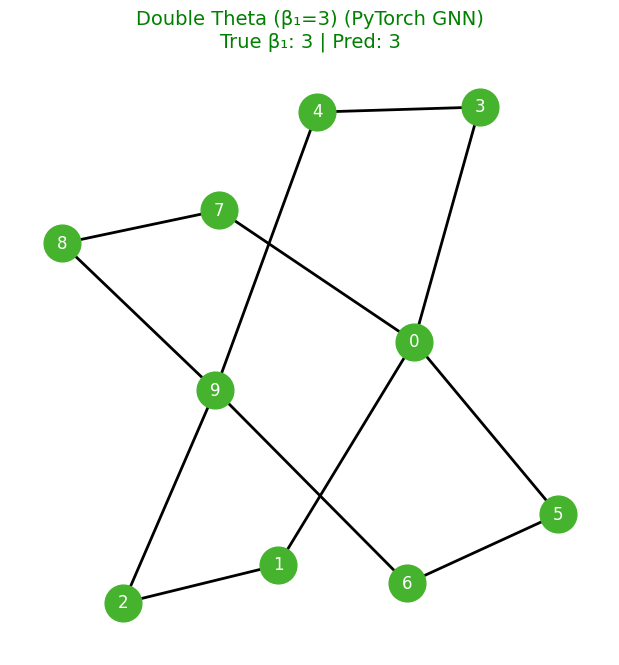


===== Subdivided Cube (β₁=4) =====
Nodes: 10, Edges: 14, Components: 1
True β₁ = 5
Predicted β₁ = 5.144 (Rounded: 5)


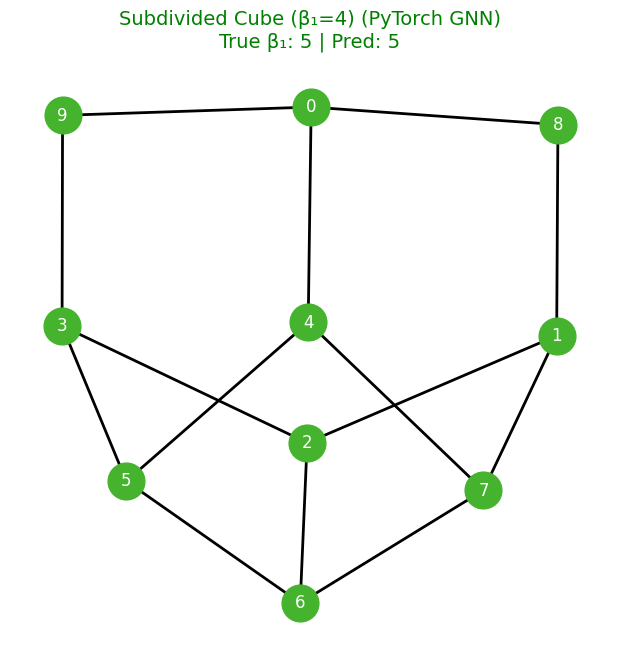


===== C10 (β₁=1) =====
Nodes: 10, Edges: 10, Components: 1
True β₁ = 1
Predicted β₁ = 1.091 (Rounded: 1)


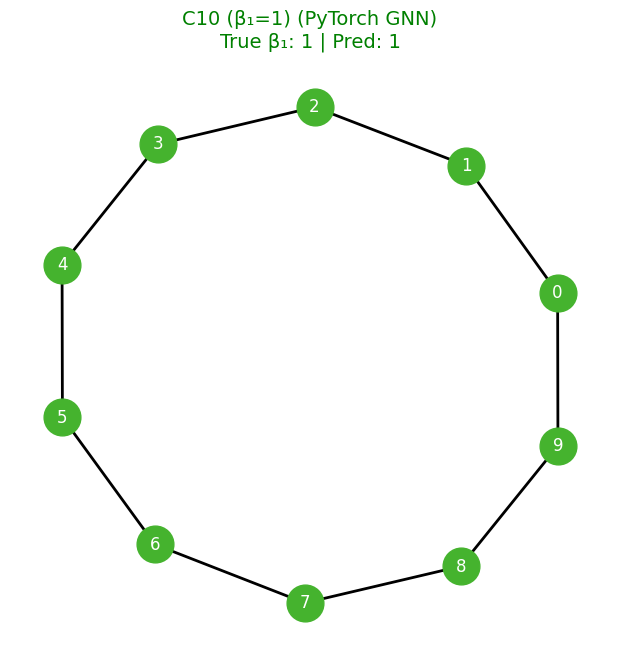


===== C5+Path (β₁=1) =====
Nodes: 10, Edges: 10, Components: 1
True β₁ = 1
Predicted β₁ = 1.120 (Rounded: 1)


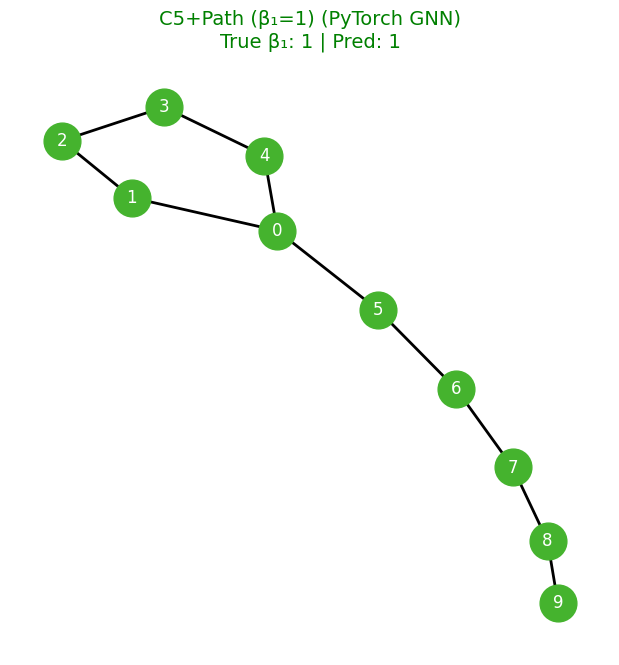


===== Path Tree (β₁=0) =====
Nodes: 10, Edges: 9, Components: 1
True β₁ = 0
Predicted β₁ = 0.366 (Rounded: 0)


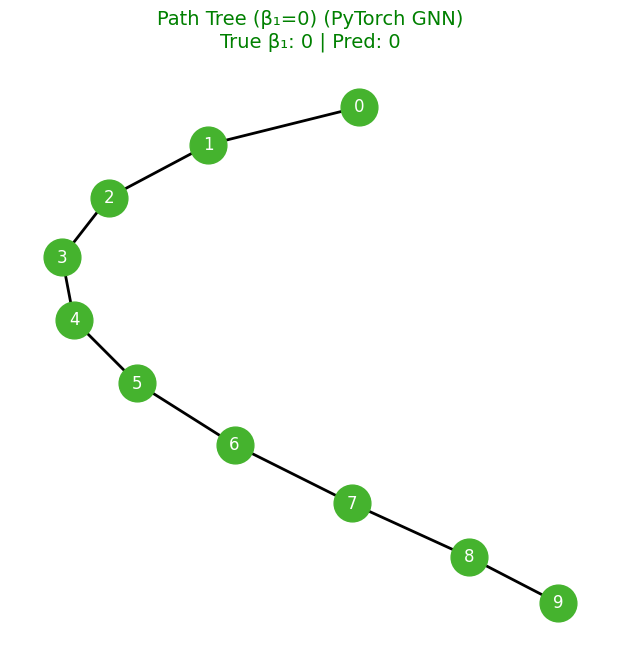


===== Star Tree (β₁=0) =====
Nodes: 10, Edges: 9, Components: 1
True β₁ = 0
Predicted β₁ = 2.872 (Rounded: 3)


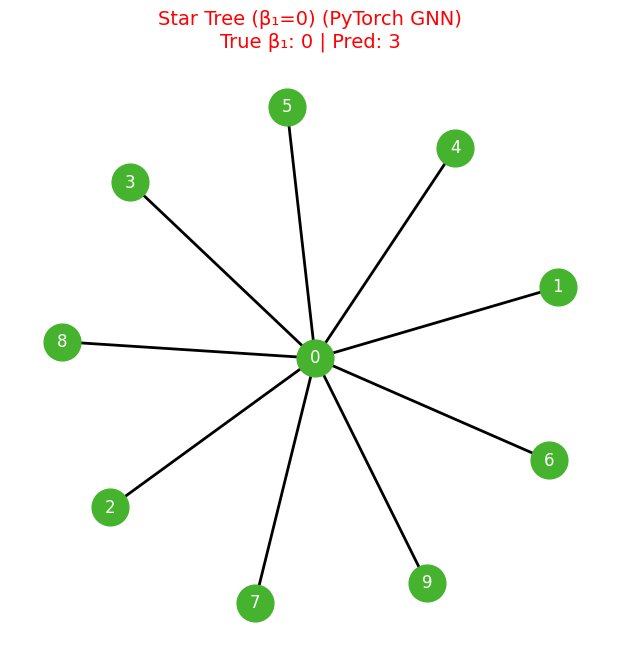


===== Mercedes-Benz (β₁=3) =====
Nodes: 10, Edges: 12, Components: 1
True β₁ = 3
Predicted β₁ = 3.209 (Rounded: 3)


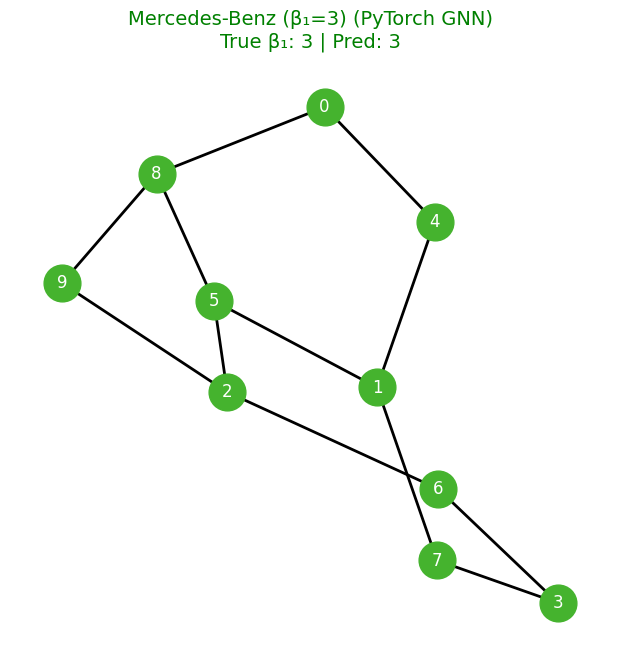


===== Two C5s (β₁=2) =====
Nodes: 10, Edges: 10, Components: 2
True β₁ = 2
Predicted β₁ = 0.956 (Rounded: 1)


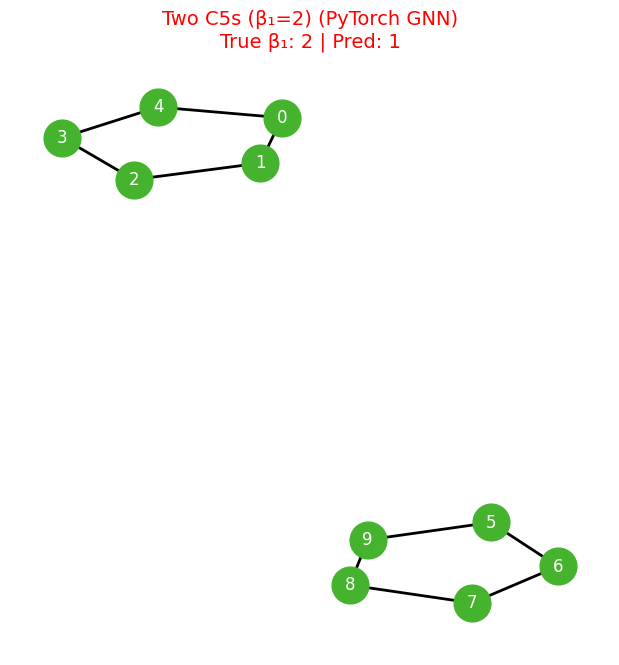

In [38]:
# --- Run Final Visualization Harness for BOTH models ---
graphs_to_test = make_specific_graphs_on_10_vertices()

# Model 1: NumPy
predict_and_visualize_numpy(graphs_to_test, betti_nn)

# Model 2: PyTorch MLP
predict_and_visualize_mlp(graphs_to_test, pytorch_mlp, device=device)

# Model 3: PyTorch GNN
predict_and_visualize_gnn(graphs_to_test, pytorch_gnn, device=device)